**Downloading the datasets library for using in the code**

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Load the dataset and put the dataset into a workspace

In [2]:
from datasets import load_dataset
import tensorflow as tf
import os
import numpy as np

# Load TrashNet dataset
dataset = load_dataset("garythung/trashnet")

# Save images locally for processing
# 0 = cardboard 1 = glass 2 = metal = 3 = paper 4 = plastic 5 = trash
train_data = dataset['train']
for idx, item in enumerate(train_data):
    image = item['image']
    label = item['label']
    dir_path = os.path.join("trashnet", str(label))
    os.makedirs(dir_path, exist_ok=True)
    image.save(os.path.join(dir_path, f"{idx}.jpg"))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

Augmentating the image for making a various of datasets

In [3]:
# Set dataset directory
dataset_dir = "trashnet"

# Create TensorFlow datasets
batch_size = 32
img_size = (128, 128)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)
# Store class names before applying map
class_names = train_ds.class_names # Store class names here

# Normalize images
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)


Found 5054 files belonging to 6 classes.
Using 4044 files for training.
Found 5054 files belonging to 6 classes.
Using 1010 files for validation.


Plotting what is inside the dataset with the label i defined

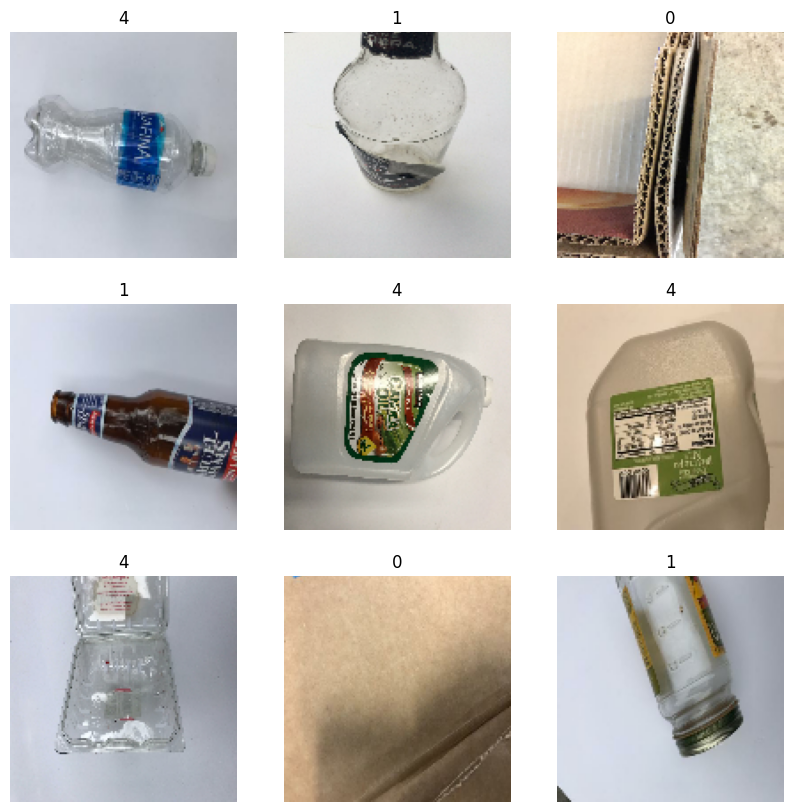

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Training the model using the datasets

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Load pretrained MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4561 - loss: 1.4563 - val_accuracy: 0.7386 - val_loss: 0.6742
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7459 - loss: 0.6689 - val_accuracy: 0.7762 - val_loss: 0.5787
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7961 - loss: 0.5524 - val_accuracy: 0.7891 - val_loss: 0.5503
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8328 - loss: 0.4636 - val_accuracy: 0.8109 - val_loss: 0.5114
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8662 - loss: 0.4047 - val_accuracy: 0.8188 - val_loss: 0.4944
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8729 - loss: 0.3763 - val_accuracy: 0.8317 - val_loss: 0.4626
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8732 - loss: 0.3519 - val_accuracy: 0.8307 - val_loss: 0.4688
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/

Plotting the training accuracy and validation accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8177 - loss: 0.4779
Validation Accuracy: 82.57%


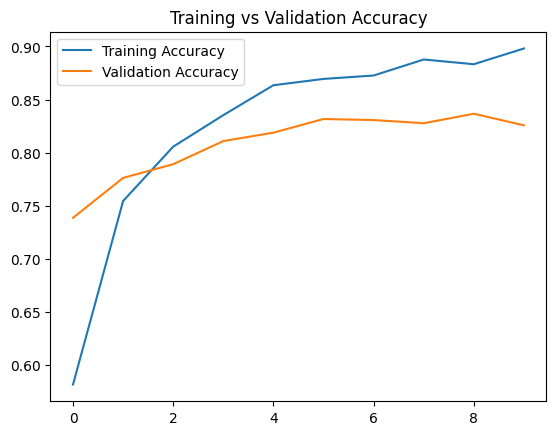

In [6]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [15]:
# prompt: create a code to test the model i already made before

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model("trash_classifier_model.h5") # Replace with your model path

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Example usage
image_path = "trashnet/2/1000.jpg" # Replace with the actual path
preprocessed_image = preprocess_image(image_path)
predictions = model.predict(preprocessed_image)

# Get the predicted class index and probabilities
predicted_class_index = np.argmax(predictions[0])
predicted_probabilities = predictions[0]

# Print the results
print("Predictions:", predictions)
print("Predicted Class Index:", predicted_class_index)
print("Predicted Probabilities:", predicted_probabilities)

# Assuming class names are available
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] # Replace with your actual class names
predicted_class = class_names[predicted_class_index]
print("Predicted Class:", predicted_class)

# Alternatively, if you have a class_names variable defined, use:
# predicted_class = class_names[predicted_class_index]
# print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions: [[0.00851837 0.01225327 0.9331694  0.00609372 0.02531597 0.01464921]]
Predicted Class Index: 2
Predicted Probabilities: [0.00851837 0.01225327 0.9331694  0.00609372 0.02531597 0.01464921]
Predicted Class: metal


In [8]:
model.save("trash_classifier_model.h5")